# Linear Regression

In [32]:
%matplotlib inline
import torch
import numpy as np
from IPython import display
from matplotlib import pyplot as plt
import random

## generate training data set 
我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征 X∈R1000×2，我们使用线性回归模型真实权重 w=[2,−3.4]
⊤和偏差 b=4.2，以及一个随机噪声项 ϵϵ 来生成标签
  
y=Xw+b+ϵ

In [33]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.from_numpy(np.random.normal(0,1,(num_examples,num_inputs)))
labels = true_w[0]*features[:,0]+true_w[1]*features[:,1]+true_b
labels += torch.from_numpy(np.random.normal(0,0.01,num_examples))

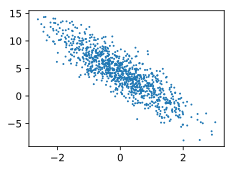

In [34]:
import d2lzh_torch
d2lzh_torch.set_figsize()
d2lzh_torch.plt.scatter(features[:,1],labels,1)


## 读取数据

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。

这里我们定义一个函数：它每次返回batch_size（批量大小）个随机样本的特征和标签。

让我们读取第一个小批量数据样本并打印。每个批量的特征形状为(10, 2)，分别对应批量大小和输入个数；标签形状为批量大小。

In [35]:
batch_size = 10
for X,y in d2lzh_torch.data_iter(batch_size,features,labels):
    print(X,y,sep='\n')
    break

tensor([[ 1.3472,  1.8996],
        [ 1.7119,  1.0029],
        [ 0.1373,  0.3043],
        [-1.2087,  0.2878],
        [-1.0170, -1.2748],
        [ 0.2009,  0.5168],
        [ 0.2981,  0.6039],
        [ 2.8818,  0.5642],
        [ 0.5662,  0.3160],
        [-1.8684, -0.4557]], dtype=torch.float64)
tensor([0.4309, 4.2196, 3.4423, 0.8140, 6.4881, 2.8215, 2.7517, 8.0530, 4.2534,
        2.0151], dtype=torch.float64)


## 初始化模型参数

我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [36]:
w = torch.tensor(np.random.normal(0,0.01,(num_inputs,1)),dtype=torch.float64) 
b = torch.zeros(1,dtype=torch.float64)
w,b

(tensor([[0.0008],
         [0.0013]], dtype=torch.float64), tensor([0.], dtype=torch.float64))

之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们要让它们的requires_grad=True

In [37]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], dtype=torch.float64, requires_grad=True)

### 定义模型

In [38]:
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b


### 定义损失函数 

In [39]:
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2


### 定义优化算法
以下的sgd函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [40]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data


### 训练模型
在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征X和标签y），通过调用反向函数backward计算小批量随机梯度，并调用优化算法sgd迭代模型参数。由于我们之前设批量大小batch_size为10，每个小批量的损失l的形状为(10, 1)。回忆一下自动求梯度一节。由于变量l并不是一个标量，所以我们可以调用.sum()将其求和得到一个标量，再运行l.backward()得到该变量有关模型参数的梯度。注意在每次更新完参数后不要忘了将参数的梯度清零。

在一个迭代周期（epoch）中，我们将完整遍历一遍data_iter函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设3和0.03。在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍

In [41]:
# d2lzh_torch修改后重新导包
import importlib
importlib.reload(d2lzh_torch)

<module 'd2lzh_torch' from '/Users/null/Documents/code/python/pytorch_learning_code/d2lzh_torch/__init__.py'>

In [42]:
lr = 0.03
num_epochs = 3
net = d2lzh_torch.linreg
loss = d2lzh_torch.squared_loss
for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in d2lzh_torch.data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        d2lzh_torch.sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.038954
epoch 2, loss 0.000140
epoch 3, loss 0.000050


In [43]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9990],
        [-3.3994]], dtype=torch.float64, requires_grad=True)
4.2 
 tensor([4.1993], dtype=torch.float64, requires_grad=True)
